In [1]:
import os

root_dir = os.path.abspath(os.path.join(os.getcwd(), "../"))
os.chdir(root_dir)

In [2]:
# import io
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.4)
# sns.set_palette("Set2")
import functions

from multiprocessing import Pool
from functools import partial

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import matthews_corrcoef
from Bio.SeqUtils.ProtParam import ProteinAnalysis

# from ipywidgets import interact
# import ipywidgets as widgets
from scipy.signal import savgol_filter

%load_ext autoreload
%autoreload 2



# Kyte & Doolittle index of hydrophobicity
# J. Mol. Biol. 157:105-132(1982).
kd = {"A": 1.8, "R": -4.5, "N": -3.5, "D": -3.5, "C": 2.5,
      "Q": -3.5, "E": -3.5, "G": -0.4, "H": -3.2, "I": 4.5,
      "L": 3.8, "K": -3.9, "M": 1.9, "F": 2.8, "P": -1.6,
      "S": -0.8, "T": -0.7, "W": -0.9, "Y": -1.3, "V": 4.2}

#Sort kd
kd = {k: v for k, v in sorted(kd.items(), key=lambda item: item[1])}

# Flexibility
# Normalized flexibility parameters (B-values), average
# Vihinen M., Torkkila E., Riikonen P. Proteins. 19(2):141-9(1994).
flexibilities_vih = {"A": 0.984, "C": 0.906, "E": 1.094, "D": 1.068,
"G": 1.031, "F": 0.915, "I": 0.927, "H": 0.950,
"K": 1.102, "M": 0.952, "L": 0.935, "N": 1.048,
"Q": 1.037, "P": 1.049, "S": 1.046, "R": 1.008,
"T": 0.997, "W": 0.904, "V": 0.931, "Y": 0.929}

def flex(seq):
    seq = seq.replace('U', 'C')
    if len(seq) == 0:
        return 0
    else:
        return [flexibilities_vih[i] for i in seq]

def gravy(seq):
    seq = seq.replace('U', 'C')
    if len(seq) == 0:
        return 0
    else:
        return np.mean([kd[i] for i in seq])

def hydrop(seq):
    seq = seq.replace('U', 'C')
    return [kd[i] for i in seq]

def filt(seq, w=15, p=2):
    seq = seq.replace('U', 'C')
    aa = hydrop(seq)
    return savgol_filter(aa, w, p)

aa = [k for k, v in kd.items()]


def progress(iteration, total, message=None):
    '''Simple progressbar
    '''
    if message is None:
        message = ''
    bars_string = int(float(iteration) / float(total) * 50.)
    print("\r|%-50s| %d%% (%s/%s) %s "% ('█'*bars_string+ "░" * \
                                     (50 - bars_string), float(iteration)/\
                                     float(total) * 100, iteration, total, \
                                     message), end='\r', flush=True)

    if iteration == total:
        print('\nCompleted!')

aa = [k for k, v in kd.items()]
def count(seq):
    counts = [seq.count(i) for i in aa]
    return counts


In [3]:
df = pd.read_pickle('results/fungi_nonfungi.pkl.gz')
df = df.sample(frac=1, random_state=12345)

In [4]:
ll = np.arange(5)

df['Feat'] = df['Protein'].str[:22].apply(count)

dfs = np.array_split(df, 5)


In [5]:
cv_results = pd.DataFrame(columns=['Test', 'Train', 'Classifier', \
                                  'Precision', 'Recall', 'PR_AUC', \
                                  'FPR', 'TPR', 'ROC_AUC', 'MCC', 'Threshold'], index=np.arange(1, 6))
mccs = []

for j in range(5):
    test_idx = j
    train_idx = list(set(ll) - set([j]))
    
    test = dfs[j].copy()
    train = pd.concat([dfs[i] for i in train_idx]).copy()

    train = train.reset_index(drop=True)
    train = train.sample(frac=1, random_state=12345).copy()
    
    #Making random forest
    
    
    
    X_train = [i for i in train['Feat']]
    y_train = train['Label'].values
    
    X_test = [i for i in test['Feat']]
    y_test = test['Label'].values
    
    
    cv_results.loc[j+1]['Train'] = [X_train, y_train]
    cv_results.loc[j+1]['Test'] = [X_test, y_test]
    
    clf = RandomForestClassifier(random_state=12345)
    clf.fit(X_train, y_train)

    cv_results.loc[j+1]['Classifier'] = clf


    preds = [i[1] for i in clf.predict_proba(X_test)]
    dfs[j]['SP_Prediction'] = preds

    #Precision, recall
#     precision, recall, _ = precision_recall_curve(y_test, preds, )
#     pr_auc = auc(recall, precision)
    
#     cv_results.loc[j+1][['Precision', 'Recall', 'PR_AUC']] = [precision], [recall], pr_auc

    
#     cv_results.loc[j+1][['FPR', 'TPR', 'ROC_AUC']] = [fpr], [tpr], roc_auc
    
    preds = [i[1] for i in clf.predict_proba(X_test)]
    dfs[j]['SP_Prediction'] = preds



    mcc = []

    for i, v in enumerate(np.arange(0.01, 0.99, 0.01)):
        y_pred = [0 if x <= v else 1 for x in preds]
        mcc.append(matthews_corrcoef(y_test, y_pred))
    
    mccs.append(max(mcc))
    cv_results.loc[j+1]['Threshold'] = np.arange(0.01, 0.99, 0.01)[np.argmax(mcc)]
    functions.progress(j+1, 5)

for i, v in enumerate(mccs):
    print('Max MCC for round {} is {}'.format(i+1, round(v, 3)))

/Volumes/userdata/student_users/bikashkumarbhandari/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


/Volumes/userdata/student_users/bikashkumarbhandari/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


/Volumes/userdata/student_users/bikashkumarbhandari/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


/Volumes/userdata/student_users/bikashkumarbhandari/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


|██████████████████████████████████████████████████| 100% (5/5)  
Completed!
Max MCC for round 1 is 0.398
Max MCC for round 2 is 0.506
Max MCC for round 3 is 0.569
Max MCC for round 4 is 0.471
Max MCC for round 5 is 0.611


/Volumes/userdata/student_users/bikashkumarbhandari/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


In [6]:
# Overall MCC across full dataset

final_df = pd.concat(dfs)

|██████████████████████████████████████████████████| 100% (98/98)  
Completed!


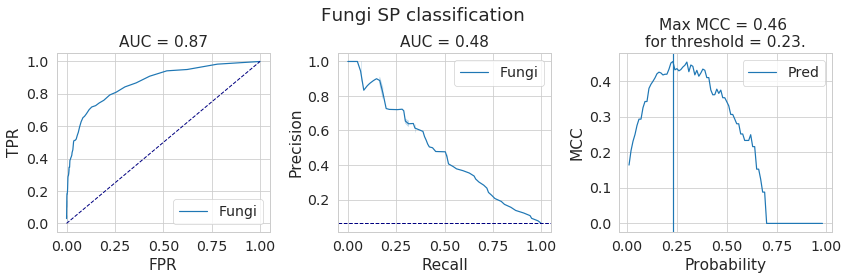

In [7]:
preds = final_df['SP_Prediction']
y = final_df['Label']

#Precision, recall
precision, recall, _ = precision_recall_curve(y, preds, )
lr_auc = auc(recall, precision)


#ROC

fpr, tpr, _ = roc_curve(y, preds)
roc_auc = auc(fpr, tpr)


from sklearn.metrics import matthews_corrcoef

mcc = []

for i, v in enumerate(np.arange(0.01, 0.99, 0.01)):
    y_pred = [0 if x <= v else 1 for x in preds]
    mcc.append(matthews_corrcoef(y, y_pred))
    functions.progress(i+1, 98)


fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4),)


sns.lineplot(fpr, tpr, label='Fungi', ax=ax[0])
#baseline
ax[0].plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')

sns.lineplot(recall, precision, label='Fungi', ax=ax[1])
#baseline
baseline = final_df.Label.value_counts()[1]/final_df.shape[0]

ax[1].axhline(y=baseline, color='navy', lw=1, linestyle='--')

ax[0].set_title('AUC = {auc}'.format(auc=round(roc_auc, 2)))
ax[0].set_xlabel('FPR')
ax[0].set_ylabel('TPR')


ax[1].set_title('AUC = {auc}'.format(auc=round(lr_auc, 2)))
ax[1].set_xlabel('Recall')
ax[1].set_ylabel('Precision')


sns.lineplot(np.arange(0.01, 0.99, 0.01), mcc, label='Pred', ax=ax[2])
ax[2].set_xlabel('Probability')
ax[2].set_ylabel('MCC')
plt.axvline(x=np.arange(0.01, 0.99, 0.01)[np.argmax(mcc)])
plt.title('Max MCC = {} \nfor threshold = {}.'.format(round(max(mcc), 2), \
                                                    round(np.arange(0.01, 0.99, 0.01)[np.argmax(mcc)], 2)));
plt.suptitle('Fungi SP classification')
fig.tight_layout()

In [8]:
final_df.to_pickle('results/fungi_for_overall_MCC.pkl.gz')

In [9]:
classifiers = cv_results[['Classifier', 'Threshold']].copy()
classifiers.head()

,Classifier,Threshold
1,"(DecisionTreeClassifier(max_features='auto', r...",0.62
2,"(DecisionTreeClassifier(max_features='auto', r...",0.22
3,"(DecisionTreeClassifier(max_features='auto', r...",0.35
4,"(DecisionTreeClassifier(max_features='auto', r...",0.3
5,"(DecisionTreeClassifier(max_features='auto', r...",0.23


In [10]:
classifiers.to_pickle('results/Fungi_Classifier.pkl.gz')